## Rodrigo Xavier
## Matrícula 569037

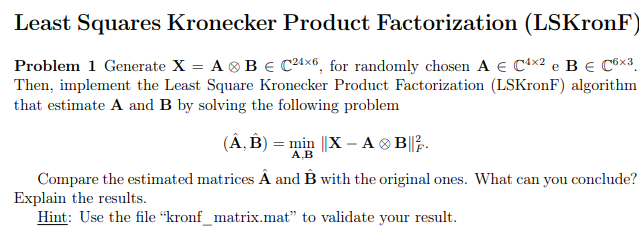

In [3]:
import numpy as np
from scipy.linalg import svd
from typing import Union

#### Functions
def dB2linear(x: Union[int, np.ndarray]) -> any:
    """ Function to convert logarithmic scale to linear.
    Parameters:
    ---
    x : [scalar or 2-D array]
        Input data [dB].

    Returns:
    ---
    out: [scalar or 2-D array]
        Output data [linear (e.g.: watts)].
    """
    return 10**(x/10)

def alphaV(X: np.ndarray, snr_db: Union[int, float]):
    """Function to compute 'a' to control the noise of a signal."""
    V = np.random.normal(0, 1, X.shape) + 1j*np.random.normal(0, 1, X.shape)
    snr_linear = dB2linear(snr_db)
    alphaV_ = (np.linalg.norm(X, 'fro')**2)/snr_linear
    alpha = np.sqrt(alphaV_/(np.linalg.norm(X, 'fro')**2))
    return alpha*V

def LSKronF(X, M, N, P, Q, SNR_dB):
    """
    Perform Least-Squares Kronecker Factorization.

    Parameters:
    - X: np.ndarray, the input matrix of shape (M*P, N*Q)
    - M, N: int, dimensions of A
    - P, Q: int, dimensions of B

    Returns:
    - A_hat: np.ndarray, estimated matrix A of shape (M, N)
    - B_hat: np.ndarray, estimated matrix B of shape (P, Q)
    """
    
    # Step 1: Rearrange X into a reshaped matrix X_tilde of shape (P*Q, M*N)
    X_tilde = np.zeros((P * Q, M * N), dtype=np.complex128)
    
    # Adding AWGN noise:
    if SNR_dB is not None:
        X = X + alphaV(X, SNR_dB)

    for m in range(M):
        for n in range(N):
            # Debug: Check block extraction
            block = X[m * P:(m + 1) * P, n * Q:(n + 1) * Q]

            if block.shape != (P, Q):
                raise ValueError(f"Block shape mismatch: {block.shape}, Expected: ({P}, {Q})")

            X_tilde[:, m * N + n] = block.flatten()

    # Step 2: Solve the least-squares problem using SVD
    U, S, Vt = svd(X_tilde, full_matrices=False)

    # Rank-1 approximation
    u1 = U[:, 0]  # First left singular vector
    v1 = Vt[0, :]  # First right singular vector
    sigma1 = S[0]  # Largest singular value

    # Step 3: Reconstruct A_hat and B_hat
    B_hat = np.sqrt(sigma1) * u1.reshape(P, Q)
    A_hat = np.sqrt(sigma1) * v1.reshape(M, N)

    return A_hat, B_hat

def NMSE(X0, X_hat):
    """
    Calculates the normalized mean square error (NMSE).

    Args:
        X0: Original data matrix.
        X_hat: Reconstructed data matrix.

    Returns:
        NMSE value.
    """
    return np.linalg.norm(X0 - X_hat)**2 / np.linalg.norm(X0)**2

In [56]:
# Testing with Practice_4_kronf_matrix.mat:
mat_file = loadmat(r"C:\Users\Administrador\Documents\Doutorado\Algebra tensorial\Homeworks\Arquivos\data_homework_4\data_homework_4\Practice_4_kronf_matrix.mat")
A_true = mat_file['A']
B_true = mat_file['B']
X_true = mat_file['X']

# Dimensions
M, N = A_true.shape  # Dimensions of A
P, Q = B_true.shape  # Dimensions of B

# Factorize X and obtain X_hat
A_hat, B_hat = LSKronF(X_true, M, N, P, Q, None)
X_hat = np.kron(A_hat, B_hat)

print("NMSE A_hat= ", NMSE(A_true, A_hat))
print("NMSE B_hat= ", NMSE(B_true, B_hat))
print("NMSE X_hat=", NMSE(X_true, X_hat))
print("")

NMSE A_hat=  0.02902203365724442
NMSE B_hat=  0.042164499726258756
NMSE X_hat= 2.0231740976536452e-31



Nota-se que a função LSKronF é capaz de estimar X_hat com um erro muito próximo de zero, quando não há ruído.

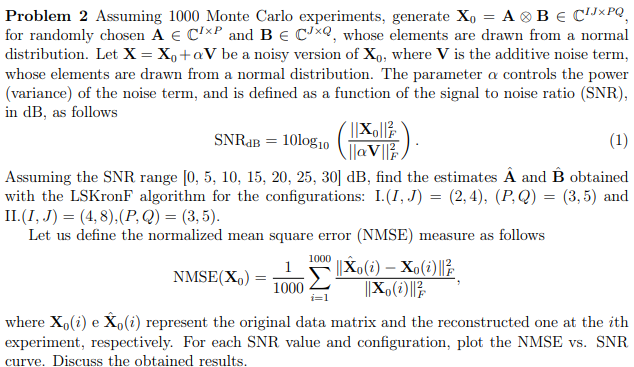

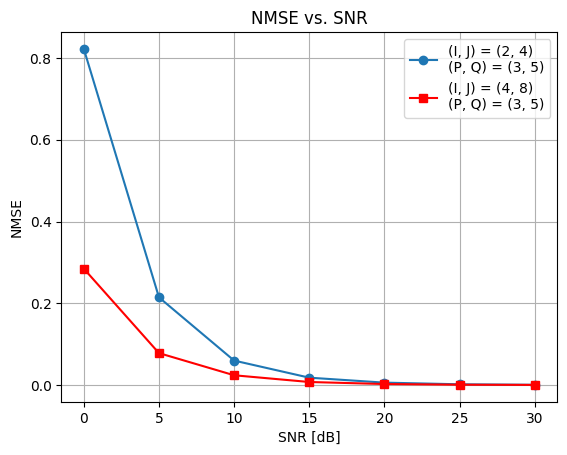

In [54]:
I1, J1 = 2, 4  # First set of parameters
P1, Q1 = 3, 5  # First set of parameters

I2, J2 = 4, 8  # Second set of parameters

SNR_dB_range = [0, 5, 10, 15, 20, 25, 30]
num_experiments = 1000

# Run simulations for the first set of parameters (I1, J1, P1, Q1)
nmse_results1 = np.zeros((num_experiments, len(SNR_dB_range)))
for ind_run in range(num_experiments):
    for snr_idx, snr in enumerate(SNR_dB_range):
        A = np.random.randn(I1, J1)
        B = np.random.randn(P1, Q1)
        X = np.kron(A, B)
        A_hat, B_hat = LSKronF(X, I1, J1, P1, Q1, snr)
        X_hat = np.kron(A_hat, B_hat)
        nmse_results1[ind_run, snr_idx] = NMSE(X, X_hat)

# Take the mean of the independent runs (for the first set)
nmse_results1 = nmse_results1.mean(axis=0)

# Run simulations for the second set of parameters (I2, J2, P1, Q1)
nmse_results2 = np.zeros((num_experiments, len(SNR_dB_range)))
for ind_run in range(num_experiments):
    for snr_idx, snr in enumerate(SNR_dB_range):
        A = np.random.randn(I2, J2)  # Use I2 and J2 for the second set
        B = np.random.randn(P1, Q1)  # Keep P1 and Q1 the same
        X = np.kron(A, B)
        A_hat, B_hat = LSKronF(X, I2, J2, P1, Q1, snr)
        X_hat = np.kron(A_hat, B_hat)
        nmse_results2[ind_run, snr_idx] = NMSE(X, X_hat)

# Take the mean of the independent runs (for the second set)
nmse_results2 = nmse_results2.mean(axis=0)

######## ######## ########
# Plotting
_ = plt.figure()  # Create a new figure for clarity

# Plot results for the first set of parameters (I1, J1, P1, Q1)
plt.plot(SNR_dB_range, nmse_results1, marker='o', label="(I, J) = ({}, {})\n(P, Q) = ({}, {})".format(I1, J1, P1, Q1))

# Plot results for the second set of parameters (I2, J2, P1, Q1)
plt.plot(SNR_dB_range, nmse_results2, marker='s', label="(I, J) = ({}, {})\n(P, Q) = ({}, {})".format(I2, J2, P1, Q1), color='red')

plt.grid(True, which="both")
plt.xlabel("SNR [dB]")
plt.ylabel("NMSE")
plt.legend()
plt.title("NMSE vs. SNR")
plt.show()